In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import gensim
from gensim import corpora
pd.set_option("display.max_colwidth", 200)
import operator
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import operator
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline

In [2]:
path = ('../sentimental_heckha/data/train.csv')
train = pd.read_csv(path)
train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1


In [3]:
train.drop(['tweet_id','sentiment'],1,inplace=True)

In [4]:
train.head()

,tweet
0,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller
1,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw"
2,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}"
3,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
4,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link}


In [5]:
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
import nltk
# declare empty list 'corpus'
corpus = []
# for loop to fill in corpus
for i in range(train.shape[0]):
    # retain alphabets
    review = re.sub('[^a-zA-Z]',' ',str(train['tweet'][i]))
    # convert to lower case
    review = review.lower()
    # tokenize
    review=review.split()
    stop_words = list(set(stopwords.words('english')))+list(punctuation)+['``', "'s", "...", "n't", r'<.*?>','br','SXSW','Apple','iphone','mention','RT','Android','link','rt','store','app','Social Network','go','u','get','take','use','line','win','know','like','call','open']
    # initialize stemmer object
    ps = PorterStemmer()
    # perform stemming
    review = [ps.stem(word) for word in review if not word in stop_words]
    # join elements of list
    review = ' '.join(review)
    # add to 'corpus'
    corpus.append(review)
print(corpus)

['sxswnui sxsw appl defin languag touch differ dialect becom smaller', 'learn ab googl doodl doodl light funni amp innov except signific occas googledoodl sxsw', 'one face ex steal show yr quot sxsw appl school mkt expert quot', 'sxsw would b pretti awesom crash everi min extend brows fuckit illmakeitwork', 'outsid appl austin wait new ipad sxsw', 'technew one lone dude await ipad appl sxsw tech news appl ipad sxsw tablet tech', 'sxsw tip princ npr video toy shop zuckerberg sxsw ipad', 'nu user new ubersoci includ uberguid sxsw sponsor mashabl', 'free sxsw sampler itun freemus', 'think might weekend without see ipad case twice sxsw', 'offici sxsw sxsw bit ly hmiiga android ipad', 'offici buy ipad sxsw elev', 'give away ipad x box book sxsw techenvi', 'offici sxsw come grill us w zazzlsxsw make case', 'compani watch sxsw trade show floor app featur hardwar ipad', 'googl marissa mayer futur locat augment realiti contextu discoveri make smartphon smarter sxsw', 'dl calyp calyp casa sxsw f

In [6]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

preprocess_word(str(corpus))

'[sxswnui sxsw appl defin languag touch differ dialect becom smaller, learn ab googl doodl doodl light funni amp innov except signific occas googledoodl sxsw, one face ex steal show yr quot sxsw appl school mkt expert quot, sxsw would b pretti awesom crash everi min extend brows fuckit illmakeitwork, outsid appl austin wait new ipad sxsw, technew one lone dude await ipad appl sxsw tech news appl ipad sxsw tablet tech, sxsw tip princ npr video toy shop zuckerberg sxsw ipad, nu user new ubersoci includ uberguid sxsw sponsor mashabl, free sxsw sampler itun freemus, think might weekend without see ipad case twice sxsw, offici sxsw sxsw bit ly hmiiga android ipad, offici buy ipad sxsw elev, give away ipad x box book sxsw techenvi, offici sxsw come grill us w zazzlsxsw make case, compani watch sxsw trade show floor app featur hardwar ipad, googl marissa mayer futur locat augment realiti contextu discoveri make smartphon smarter sxsw, dl calyp calyp casa sxsw free mobil avail itun amp android

In [7]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

handle_emojis(str(corpus))

"['sxswnui sxsw appl defin languag touch differ dialect becom smaller', 'learn ab googl doodl doodl light funni amp innov except signific occas googledoodl sxsw', 'one face ex steal show yr quot sxsw appl school mkt expert quot', 'sxsw would b pretti awesom crash everi min extend brows fuckit illmakeitwork', 'outsid appl austin wait new ipad sxsw', 'technew one lone dude await ipad appl sxsw tech news appl ipad sxsw tablet tech', 'sxsw tip princ npr video toy shop zuckerberg sxsw ipad', 'nu user new ubersoci includ uberguid sxsw sponsor mashabl', 'free sxsw sampler itun freemus', 'think might weekend without see ipad case twice sxsw', 'offici sxsw sxsw bit ly hmiiga android ipad', 'offici buy ipad sxsw elev', 'give away ipad x box book sxsw techenvi', 'offici sxsw come grill us w zazzlsxsw make case', 'compani watch sxsw trade show floor app featur hardwar ipad', 'googl marissa mayer futur locat augment realiti contextu discoveri make smartphon smarter sxsw', 'dl calyp calyp casa sxsw 

### Let's remove some common words that every tweet description contain. Display top 10 most occuring words

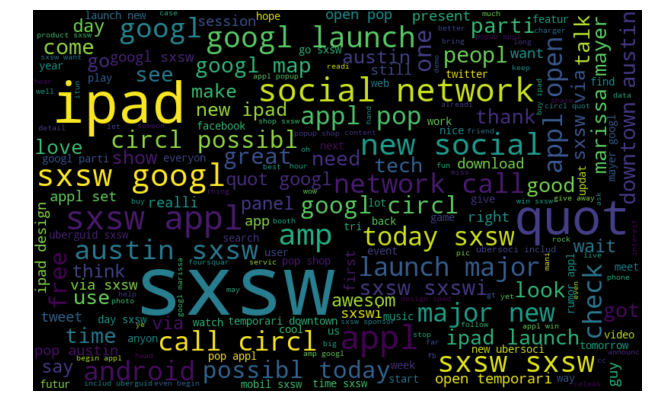

In [8]:
#plotting the wordcloud of positive sentiments
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in corpus])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [9]:
# train['tweet'] = train['tweet'].apply(lambda x:re.sub('[^a-zA-Z]', ' ',x))

# # Remove unnecesary space
# train['tweet'] = train['tweet'].apply(lambda x:re.sub(' +', ' ',x))

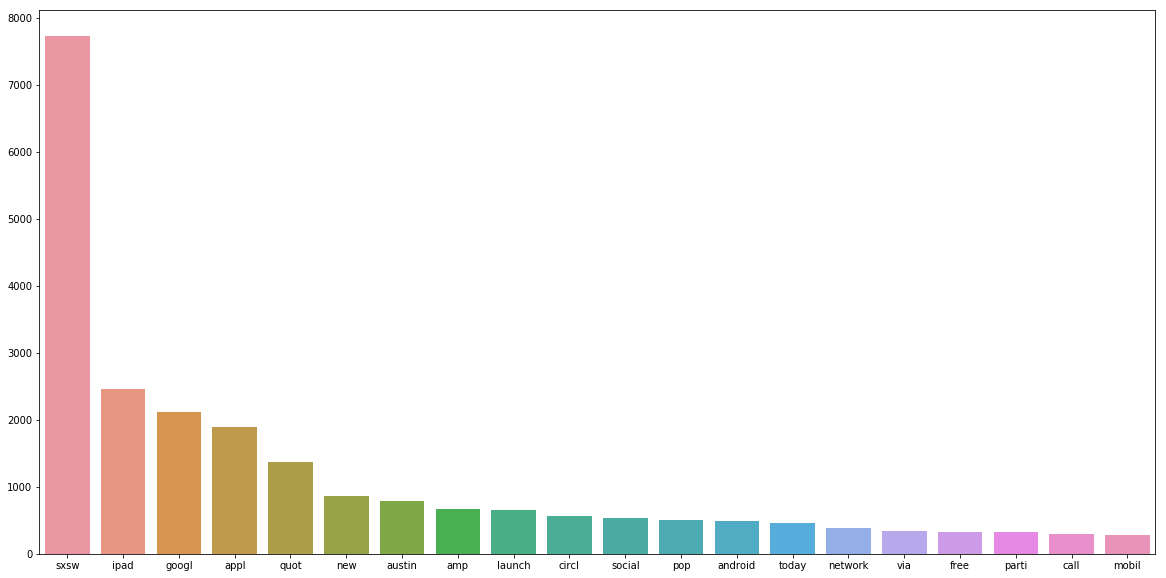

In [10]:
# # List of some common words 
# stop_set = ['social','want','still','look','love','googl','use','great','austin','talk','circl possibl','need','major','free','go','down town','got','session']
# #  removing stop words
# stop = set(stopwords.words('english'))
# for word in stop_set:
#     stop.add(word)
# custom = list(stop)+list(punctuation)

# Initialize CountVectorizer
vectorizer = CountVectorizer()
# Transform job description
description = vectorizer.fit_transform(corpus)
# initialize empty dictionary
words = {}
# initialize with 0
i = 0

# Number of time every feature appears over the entire document
sums = np.array(np.sum(description, axis=0)).flatten()

# Loop to map 'sums' to its word
for word in vectorizer.get_feature_names():
    words[word] = sums[i]
    i += 1
# Top 20 most occuring words
top_20 = sorted(words.items(), key=operator.itemgetter(1), reverse=True)[:20]
# Display top 20 words
top_20_words = [i[0] for i in top_20]
top_20_values = [i[1] for i in top_20]
plt.figure(figsize=(20,10))
sns.barplot(top_20_words,top_20_values)
plt.show()

In [16]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim.models.lsimodel import LsiModel
from gensim import corpora
from pprint import pprint
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
# Function to lemmatize and remove the stopwords
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in corpus])
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
# Creating a list of documents from the complaints column
#list_of_docs = job_requirement["job_desc"].tolist()

# Implementing the function for all the complaints of list_of_docs
doc_clean = [clean(doc).split() for doc in corpus]
print(doc_clean[:2])

# Code starts here

# Creating the dictionary id2word from our cleaned word list doc_clean
dictionary = corpora.Dictionary(doc_clean)

# Creating the corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Creating the LSi model
lsimodel = LsiModel(corpus=doc_term_matrix, num_topics=5, id2word=dictionary)
pprint(lsimodel.print_topics())

[['sxswnui', 'sxsw', 'appl', 'defin', 'languag', 'touch', 'differ', 'dialect', 'becom', 'smaller'], ['learn', 'ab', 'googl', 'doodl', 'doodl', 'light', 'funni', 'amp', 'innov', 'except', 'signific', 'occas', 'googledoodl', 'sxsw']]
[(0,
  '0.828*"sxsw" + 0.289*"ipad" + 0.236*"googl" + 0.230*"appl" + 0.181*"quot" + '
  '0.102*"new" + 0.092*"austin" + 0.083*"launch" + 0.071*"circl" + '
  '0.070*"amp"'),
 (1,
  '0.557*"googl" + -0.426*"ipad" + -0.354*"appl" + 0.249*"circl" + '
  '0.240*"quot" + 0.221*"social" + 0.188*"network" + 0.180*"new" + '
  '0.163*"launch" + 0.144*"call"'),
 (2,
  '-0.934*"quot" + 0.127*"googl" + 0.115*"sxsw" + 0.114*"circl" + '
  '0.110*"launch" + 0.103*"social" + 0.100*"new" + 0.100*"network" + '
  '0.088*"today" + 0.081*"call"'),
 (3,
  '0.727*"appl" + -0.513*"ipad" + 0.211*"pop" + 0.190*"austin" + '
  '0.111*"launch" + 0.111*"open" + -0.090*"sxsw" + 0.077*"circl" + '
  '0.077*"temporari" + 0.073*"social"'),
 (4,
  '-0.505*"ipad" + -0.301*"new" + -0.291*"launch" 

### Model buliding with LDA

In [17]:
# imports
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
# This variable is already available.

# Code starts here

# Creating the dictionary id2word from our cleaned word list doc_clean
dictionary = corpora.Dictionary(doc_clean)

# Creating the corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]


# Creating the LDA model
ldamodel = LdaMulticore(corpus=doc_term_matrix, num_topics=5,id2word=dictionary, random_state=20, passes=30, workers= 12)

# printing the topics
pprint(ldamodel.print_topics())

[(0,
  '0.088*"sxsw" + 0.032*"ipad" + 0.022*"new" + 0.013*"android" + 0.009*"appl" '
  '+ 0.008*"amp" + 0.008*"game" + 0.007*"includ" + 0.007*"mobil" + '
  '0.007*"austin"'),
 (1,
  '0.115*"sxsw" + 0.073*"appl" + 0.062*"ipad" + 0.031*"austin" + 0.021*"pop" + '
  '0.011*"open" + 0.009*"temporari" + 0.008*"downtown" + 0.007*"popup" + '
  '0.007*"launch"'),
 (2,
  '0.090*"quot" + 0.084*"sxsw" + 0.046*"googl" + 0.037*"circl" + '
  '0.034*"social" + 0.032*"launch" + 0.030*"new" + 0.026*"network" + '
  '0.024*"today" + 0.020*"call"'),
 (3,
  '0.094*"sxsw" + 0.073*"googl" + 0.017*"amp" + 0.012*"parti" + 0.012*"map" + '
  '0.011*"mobil" + 0.009*"mayer" + 0.008*"marissa" + 0.007*"search" + '
  '0.006*"locat"'),
 (4,
  '0.099*"sxsw" + 0.036*"ipad" + 0.019*"free" + 0.015*"android" + '
  '0.013*"design" + 0.010*"amp" + 0.010*"download" + 0.008*"w" + 0.008*"music" '
  '+ 0.007*"itun"')]


In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.067420  0.149498       1        1  29.814631
3      0.001098 -0.166952       2        1  24.032461
2     -0.235120  0.032019       3        1  19.124105
4      0.107439 -0.031193       4        1  15.126748
0      0.059163  0.016627       5        1  11.902062, topic_info=     Category         Freq        Term        Total  loglift  logprob
27    Default  1252.000000        quot  1252.000000  30.0000  30.0000
15    Default  1940.000000       googl  1940.000000  29.0000  29.0000
0     Default  1719.000000        appl  1719.000000  28.0000  28.0000
151   Default   518.000000       circl   518.000000  27.0000  27.0000
156   Default   491.000000      social   491.000000  26.0000  26.0000
44    Default  2255.000000        ipad  2255.000000  25.0000  25.0000
152   Default   600.000000      launch   600.000000  24.0000  24.0000
43    Default   724.000000      austin   724.000000  23.0000  23.0000
154   Default   358.000000     network   358.000000  22.0000  22.0000
136   Default   456.000000         pop   456.000000  21.0000  21.0000
45    Default   794.000000         new   794.000000  20.0000  20.0000
150   Default   270.000000        call   270.000000  19.0000  19.0000
157   Default   428.000000       today   428.000000  18.0000  18.0000
153   Default   224.000000       major   224.000000  17.0000  17.0000
69    Default   300.000000        free   300.000000  16.0000  16.0000
155   Default   186.000000     possibl   186.000000  15.0000  15.0000
239   Default   202.000000         map   202.000000  14.0000  14.0000
80    Default   449.000000     android   449.000000  13.0000  13.0000
135   Default   235.000000        open   235.000000  12.0000  12.0000
121   Default   261.000000       mobil   261.000000  11.0000  11.0000
7     Default  7094.000000        sxsw  7094.000000  10.0000  10.0000
533   Default   186.000000      design   186.000000   9.0000   9.0000
576   Default   193.000000   temporari   193.000000   8.0000   8.0000
112   Default   160.000000       mayer   160.000000   7.0000   7.0000
111   Default   139.000000     marissa   139.000000   6.0000   6.0000
159   Default   295.000000       parti   295.000000   5.0000   5.0000
298   Default   108.000000    download   108.000000   4.0000   4.0000
254   Default   162.000000    downtown   162.000000   3.0000   3.0000
308   Default   158.000000       popup   158.000000   2.0000   2.0000
346   Default   120.000000      search   120.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
924    Topic5    11.215117         vip    12.949299   1.9847  -6.6413
62     Topic5    64.139732      includ    84.350952   1.8545  -4.8975
323    Topic5    41.379826      follow    54.400627   1.8549  -5.3358
229    Topic5    70.107552        game   110.397324   1.6744  -4.8085
2795   Topic5    15.135205     blogger    19.357658   1.8824  -6.3415
1038   Topic5    20.333065      meetup    28.508003   1.7905  -6.0463
327    Topic5    52.737625       updat    93.686714   1.5538  -5.0932
60     Topic5    54.745266       video   100.128487   1.5247  -5.0559
1166   Topic5    19.020624        cont    26.702560   1.7892  -6.1130
773    Topic5    23.687368        blog    36.868267   1.6860  -5.8936
484    Topic5    34.797615  blackberri    65.271393   1.4995  -5.5090
45     Topic5   188.509857         new   794.891357   0.6894  -3.8194
7      Topic5   752.797241        sxsw  7094.937012  -0.1149  -2.4348
80     Topic5   112.616562     android   449.824707   0.7436  -4.3346
321    Topic5    31.239519           v    65.271255   1.3916  -5.6169
44     Topic5   276.859985        ipad  2255.818604   0.0307  -3.4351
99     Topic5    53.035759         app   166.632965   0.9836  -5.0876
866    Topic5    37.286892          pm    92.670265   1.2181  -5.4399
167    Topic5    54.021099        need   181.467453   0.9168  -5.0692
774    To